In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import winsound
import sounddevice as sd
import pandas as pd
from scipy import signal
from scipy.fftpack import fft, fftshift
import peakutils
import soundfile   as sf

In [2]:
def calcFFT(signal, fs):
    # https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
    #y  = np.append(signal, np.zeros(len(signal)*fs))
    N  = len(signal)
    T  = 1/fs
    xf = np.linspace(-1.0/(2.0*T), 1.0/(2.0*T), N)
    yf = fft(signal)
    return(xf, fftshift(yf))

In [3]:
def generateSin(freq, time, fs):
    n = time*fs #numero de pontos
    x = np.linspace(0.0, time, n)  # eixo do tempo
    s = np.sin(freq*x*2*np.pi)
    return (x, s)

In [4]:
def plotFFT(signal, fs):
    x,y = calcFFT(signal, fs)
    plt.figure()
    plt.plot(x, np.abs(y))
    plt.title('Fourier')
    plt.show()
    return x,y

In [5]:
digitos_dict = {}
digitos_dict["Frequencia"] = [697, 770, 852, 941]
digitos_dict[1209] = [1, 4, 7, "X"]
digitos_dict[1336] = [2, 5, 8, "0"]
digitos_dict[1477] = [3, 6, 9, "#"]
digitos_dict[1633] = ["A", "B", "C", "D"]

In [6]:
digitos_df = pd.DataFrame(digitos_dict)
digitos_df = digitos_df.set_index("Frequencia")
digitos_df

,1209,1336,1477,1633
Frequencia,,,,
697,1,2,3,A
770,4,5,6,B
852,7,8,9,C
941,X,0,#,D


In [7]:
def get_number(f1, f2):
    return digitos_df[f1][f2]

In [8]:
def get_frequencies(number):
    for column, line in digitos_df.items():
        for digito in line:
            if number == digito:
                col = column
    line = digitos_df.loc[digitos_df[col]==number].index[0]    
    return col, line

In [12]:
def emissor():
    num = int(input("Digite um número: "))
    freq1, freq2 = get_frequencies(num)
    fs = 44100
    F = 1
    T = 1
    t = np.linspace(-T, T, T*fs)
    sd.default.samplerate = fs
    sd.default.channels = 1
    
    x1, y1 = generateSin(freq1,T,fs)
    x2, y2 = generateSin(freq2,T,fs)
    y3 = y1+y2
    
    
    plt.figure()
    plt.plot(t[:300], y1[:300], label= ("{} Hz".format(freq1)))
    plt.plot(t[:300], y2[:300], 'orange', label = ("{} Hz".format(freq2)))
    plt.legend()
    plt.title("Frequências do número {}".format(num))
    plt.show()
    
    plt.figure()
    plt.plot(t[:300], y3[:300], 'olive')
    plt.title("Soma de {0} Hz e {1} Hz".format(freq1, freq2))
    plt.show()
    
    y3_str = []
    for e in y3:
        y3_str.append(str(e))
        
    #sd.play(y3)
    #sd.wait()
    with open("freq.txt", "w") as file:
        file.write(str(y3_str))

Digite um número: 4


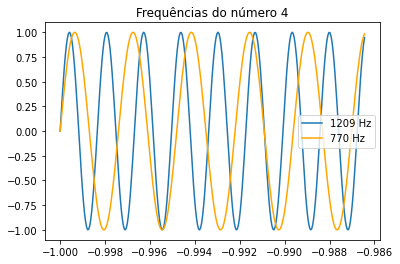

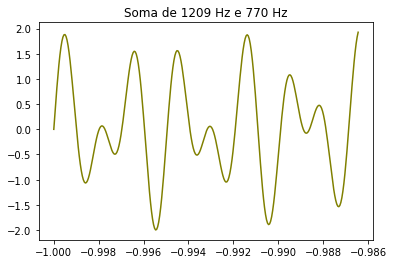

In [13]:
emissor()

In [10]:
def receptor():
    fs = 44100 
    T  = 1
    t  = np.linspace(0,T,T*fs)
    sd.default.samplerate = fs
    sd.default.channels = 1
    with open("freq.txt", "r") as file:
        myrecording = file.read()
        myrecording = eval(myrecording)
        new_myrecording = []
        for e in myrecording:
            new_myrecording.append(float(e))
    
    new_myrecording = sd.playrec(new_myrecording, fs, channels=1)
    sd.wait()
    plt.plot(t, new_myrecording, '.-')
    plt.title("Som do playrec")
    plt.show()
    sd.play(new_myrecording)
    sd.wait()
    
    x, y = plotFFT(new_myrecording[:,0], fs)
    
    index = peakutils.indexes(np.abs(y), thres=0.2, min_dist=10)
    print("Index de picos {}".format(index))
    for freq in x[index]:
        print("Frequencias de pico: {}".format(freq))
    
    print("Digito recebido: {}".format(digitos_df[index[1]][index[0]]))
    
    return(digitos_df[index[1]][index[0]])
    

Digite um número: 4


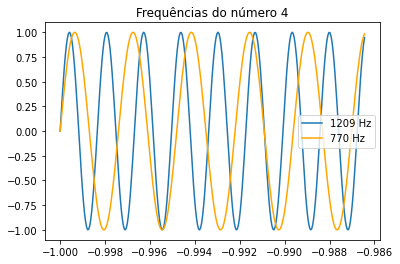

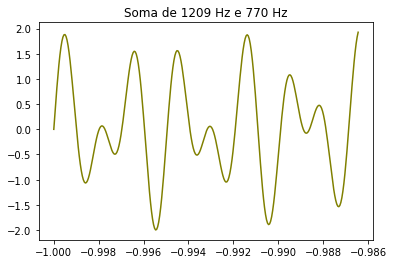

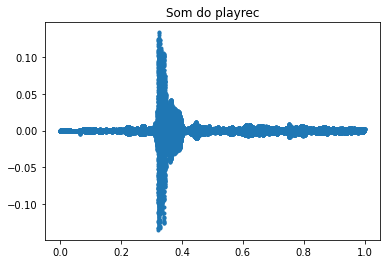

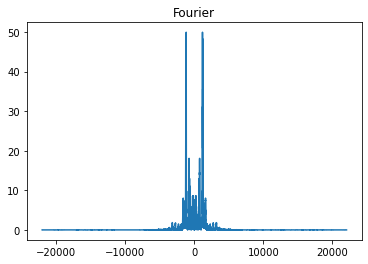

Index de picos [20796 20815 20840 20856 20872 20891 21288 21303 21351 22749 22797 22812
 23209 23228 23244 23260 23285 23304]
Frequencias de pico: -1253.5284246808333
Frequencias de pico: -1234.52799383206
Frequencias de pico: -1209.5274269257825
Frequencias de pico: -1193.5270641057614
Frequencias de pico: -1177.526701285744
Frequencias de pico: -1158.5262704369707
Frequencias de pico: -761.5172679652605
Frequencias de pico: -746.5169278214926
Frequencias de pico: -698.5158393614365
Frequencias de pico: 699.515862037686
Frequencias de pico: 747.5169504977421
Frequencias de pico: 762.51729064151
Frequencias de pico: 1159.5262931132238
Frequencias de pico: 1178.5267239619934
Frequencias de pico: 1194.5270867820145
Frequencias de pico: 1210.527449602032
Frequencias de pico: 1235.5280165083095
Frequencias de pico: 1254.5284473570828


KeyError: 20815

In [17]:
emissor()
receptor()

In [18]:
file = open("freq.txt","r+")
file.truncate(0)
file.close() 